# Empirical Dynamic Modeling for predicting NVIDIA stock price

# Abstract
Conventional data analysis relies on statistical models for forecasting and to deduce variable relationships. Statistical models contain underlying assumptions and hypothesis about the data, for example, statistical independence is often presumed between variables, which can lead to erroneous statistical estimates such as inflated correlation coefficients between variables. Empirical dynamic modeling (EDM) is a data-driven, non-parametric framework for modeling nonlinear dynamic systems with minimal assumptions. This notebook presents an implementation of EDM (Simplex Projection using Nearest Neighbor Forecasting) to predict movements of NVIDIA stock price (NVDA). 

Convergent Cross Mapping (CCM) is used to evaluate if outside variables are affecting the price of NVDA, and if adding them as features to the Simplex Projection will increase predicability of the model. Correlation is often insufficient as two variables can be highly correlated, but have no causal effect. CCM is an exploration of the cause and effect of two variables. It is done by looking at the predictability of one variable when the other variable is presumed to be the source of the dynamics.  

The price of Bitcoin (BTC), supplier company stock price, and fed interest rates were examined to see if a causal relationship existed with NVDA price. No features were discovered that added power to the model. Despite this, a model using Simplex Projection of time-delay embedded NVDA price correctly predicted day to day directional movements of NVDA. 

Next steps for this work are to identify external features that add power to the model. Since the stock market is largely affected by consumer perception/psychology, a useful feature to add to the model could be an aggregated metric of public perception of a stock based on social media feedback and news outlet articles. 

The [pyEDM library](https://github.com/SugiharaLab/pyEDM) used for this implementation was developed by the [UCSD Sugihara Lab](https://deepeco.ucsd.edu/). Installation instructions can be found [here](https://github.com/SugiharaLab/pyEDM/blob/master/README.md). 


# Introduction

## Empirical Dynamic Modeling

### Overview

A full overview of EDM and CCM can be found is this [tutorial](https://github.com/SugiharaLab/rEDM/blob/master/inst/doc/rEDM-tutorial.pdf) provided by the UCSD Sugihara Lab. Below is an abridged version of the overview. 

"_Empirical dynamic modeling (EDM) is an emerging non-parametric framework for modeling nonlinear dynamic systems._ 

_Many scientific fields use models as approximations of reality and for various purposes, for example, testing hypotheses regarding mechanisms or processes, explaining past observations, and predicting future outcomes. In many cases these models are based on hypothesized parametric equations; however, explicit equations can be impractical when the underlying mechanisms are unknown or are too complex to be characterized with existing datasets. Empirical models, which infer patterns and associations from the data (instead of using hypothesized equations), represent an alternative and highly flexible approach._

_The basic goal underlying EDM is to reconstruct the behavior of dynamic systems using time series data. Because these methods operate with minimal assumptions, they are particularly suitable for studying systems that exhibit non-equilibrium dynamics and nonlinear state-dependent behavior (i.e. where interactions change over time and as a function of the system state)._

_The essential concept is that time series can be viewed as projections of the behavior of a dynamic system. First, the system state can be described as a point in a high-dimensional space. The axes of this space can be thought of as fundamental state variables; in an ecosystem, these variables might correspond to population abundances, resources, or environmental conditions. Second, the system state changes through time following a set of deterministic rules. In other words, the behavior of the system is not completely stochastic._

_Consequently, it is possible to project the system state onto one of the coordinate axes and obtain the value of the corresponding state variable. Sequential projections over time will thus produce a time series for that variable. For example, in figure 1 the states of the canonical Lorenz Attractor (Lorenz 1963) are projected onto the x-axis, creating a time series of variable x._"

<img src="images/fig_1.png" width="500" alt="Lorenz Reconstruction" />

_As seen above, a time series can be thought of as sequential projections of the motion on an attractor; in other words, information about the behavior is encoded in the temporal ordering of the time series. Takens’ Theorem (Takens 1981) states that mathematically valid and property preserving reconstructions of the attractor can be created using lags of a single time series, then substituting those lagged time series for unknown or unobserved variables. In other words, instead of representing the system state using a complete set of state variables, we can instead use an E-dimensional lagged-coordinate embedding._ 

_If sufficient lags are used, the reconstruction preserves essential mathematical properties of the original system. Reconstructed states will map one-to-one to actual system states, and nearby points in the reconstruction will correspond to similar system states. Figure 2 shows a reconstruction of the Lorenz attractor where the reconstructed system state is comprised of 3 lags of variable x. Here, the visual similarity between the reconstruction and the original Lorenz Attractor is quite clear."_

<img src="images/fig_2.png" width="500" alt="Attractor Reconstruction" />


## Motivation
I began this project to: 

__1.__ Learn about Empirical Dynamic Modeling and familiarize myself with the pyEDM library.

__2.__ In 2017 during peak BTC prices NVDA price saw a dramatic increase that was widely attributed to increase in demand for GPUs used for crypto mining. Financial analysts tied the price of NVDA to the BTC price [(CNN Article)](https://www.cnn.com/2018/11/16/tech/nvidia-stock-earnings-cryptocurrency/index.html). Since then implementing a project forecasting NVDA stock using BTC as a feature has been in the back of my mind. 

# Implementation

## Data preparation

In [1]:
import numpy as np
import pandas as pd
import pyEDM
import datetime
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

CSVs containing the daily prices of NVDA and BTC from 10-31-2013 to 11-29-2019 are loaded into Pandas dataframes.

In [2]:
btc_df = pd.read_csv('data/btc.csv')
nvda_df = pd.read_csv('data/nvda.csv')

The string type 'Date' column is converted to a datetime type in the 'Time' column. The dataframes are then sorted by the date.

In [3]:
btc_df['Time'] = pd.to_datetime(btc_df['Date']).dt.date
nvda_df['Time'] = pd.to_datetime(nvda_df['Date']).dt.date

btc_df.sort_values(by=['Time'], ascending=True, inplace=True)
nvda_df.sort_values(by=['Time'], ascending=True, inplace=True)

In [4]:
nvda_df.head()

,Date,NVDA_open,NVDA_high,NVDA_low,NVDA_close,NVDA_volume,Time
0,10/1/13,15.58,15.655,15.465,15.55,5674400,2013-10-01
1,10/2/13,15.39,15.600,15.390,15.54,4050900,2013-10-02
2,10/3/13,15.55,15.692,15.305,15.38,10919200,2013-10-03
3,10/4/13,15.36,15.720,15.320,15.59,6155700,2013-10-04
4,10/7/13,15.53,15.700,15.450,15.59,4248800,2013-10-07


In [5]:
btc_df.head()

,Date,BTC_close,BTC_open,BTC_high,BTC_low,Time
0,10/1/13,123.65499,124.30466,124.75166,122.56349,2013-10-01
1,10/2/13,125.45500,123.65499,125.75850,123.63383,2013-10-02
2,10/3/13,108.58483,125.45500,125.66566,83.32833,2013-10-03
3,10/4/13,118.67466,108.58483,118.67500,107.05816,2013-10-04
4,10/5/13,121.33866,118.67466,121.93633,118.00566,2013-10-05


An inner join between the NVDA and BTC dataframes is performed. Note that BTC is traded every day, however NVDA is only traded when the NASDAQ is open, so BTC price is only considered for days that NVDA price is available. 

In [6]:
btc_nvda_join_df = nvda_df.merge(btc_df, 
                                 left_on='Time', 
                                 right_on='Time', 
                                 how='inner', 
                                 indicator=True)

In [7]:
btc_nvda_df = btc_nvda_join_df[['Time', 'NVDA_open', 'BTC_open']].copy()

In [8]:
btc_nvda_df.head()

,Time,NVDA_open,BTC_open
0,2013-10-01,15.58,124.30466
1,2013-10-02,15.39,123.65499
2,2013-10-03,15.55,125.45500
3,2013-10-04,15.36,108.58483
4,2013-10-07,15.53,120.65533


In [9]:
btc_nvda_df.shape

(1547, 3)

## Data exploration

### Visualize time series

The price of NVDA and BTC is plotted below. 

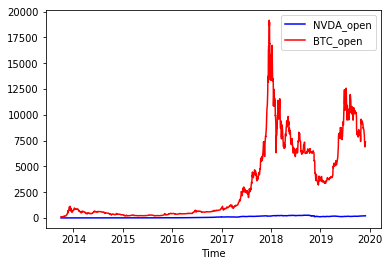

In [10]:
ax = plt.gca()
btc_nvda_df.plot(kind='line',x='Time',y='NVDA_open',color='blue',ax=ax)
btc_nvda_df.plot(kind='line',x='Time',y='BTC_open',color='red',ax=ax)
plt.show()

To adjust for the difference in range between NVDA and BTC, the features are normalized by removing the mean and scaling to unit variance.

In [11]:
scaler = StandardScaler()
btc_nvda_df['NVDA_open_scaled'] = scaler.fit_transform(btc_nvda_df[["NVDA_open"]])
btc_nvda_df['BTC_open_scaled'] = scaler.fit_transform(btc_nvda_df[["BTC_open"]])

The scaled price of NVDA and BTC is plotted below. The movement of NVDA and BTC appears to be correlated.

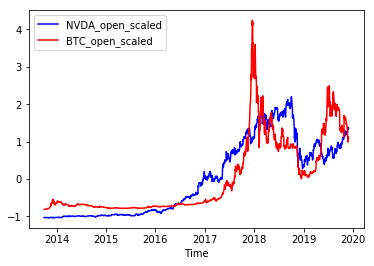

In [12]:
ax = plt.gca()
btc_nvda_df.plot(kind='line',x='Time',y='NVDA_open_scaled',color='blue',ax=ax)
btc_nvda_df.plot(kind='line',x='Time',y='BTC_open_scaled',color='red',ax=ax)
plt.show()

### Optimal Embedding Dimension

A fundamental tenant of EDM is that the system dynamics are deterministic (not purely stochastic) and low dimensional.  The first step in data exploration is to identify an optimal embedding dimension for the dynamics and subsequent analysis. __EmbedDimension()__ parallelizes function calls to __Simplex()__, which automatically sets values of E (Embedding dimension) from 1 to 10. The figure below shows the Pearson correlation coefficient between the simplex projected forecast at Tp = 1 timesteps ahead the observed data over the prediction (pred) indices for each E. Note that the model is built from the first 1300 points, but evaluated on points 1301-1547. 

The embedding dimension that best captures the dynamics of the data is identified at the peak of E = 3 in the figure below.

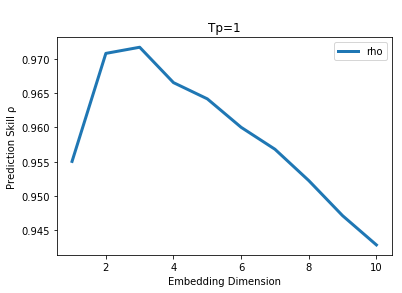

,E,rho
0,1.0,0.955047
1,2.0,0.970793
2,3.0,0.971689
3,4.0,0.966531
4,5.0,0.964166
5,6.0,0.960016
6,7.0,0.956820
7,8.0,0.952251
8,9.0,0.947137
9,10.0,0.942875


In [13]:
pyEDM.EmbedDimension(dataFrame = btc_nvda_df, 
                     lib = "1 1300", 
                     pred = "1301 1547", 
                     columns = "NVDA_open_scaled", target = "NVDA_open_scaled") 

### Prediction Decay

Linear systems should have stable predictability over all time horizons.  Nonlinear systems are expected to lose predictive skill as the forecast horizon increases.  __PredictInterval()__ automates evaluating the __Simplex()__ prediction as Tp (time steps into the future at which forecasts are made) increases. An embedding dimension of E = 3 is used. 

The figure below demonstrates that the predicability decays with the forecast interval, indicating that the dynamics are not purely linear. 

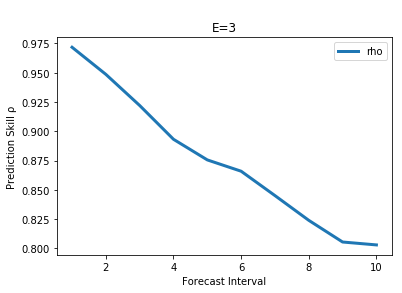

,Tp,rho
0,1.0,0.971689
1,2.0,0.948537
2,3.0,0.921976
3,4.0,0.893139
4,5.0,0.875542
5,6.0,0.865895
6,7.0,0.845100
7,8.0,0.823985
8,9.0,0.805489
9,10.0,0.803007


In [14]:
pyEDM.PredictInterval( dataFrame = btc_nvda_df, 
                       lib = "1 1300", pred = "1301 1547", E = 3, 
                       columns = "NVDA_open_scaled", target = "NVDA_open_scaled")

### Identifying Nonlinearity

From a dynamical perspective, nonlinear systems are _state-dependent_ systems. Optimal predictability should occur when the local, not the global states are considered.  __PredictNonlinear()__ parallelizes calls to __SMap()__ to assess predictive skill as a function of the nearest neighbor localization parameter.

Using an embedding dimension of E = 3, the peak of Prediction skill at a non zero theta indicates state dependence. This is further indication of nonlinear dynamics.  

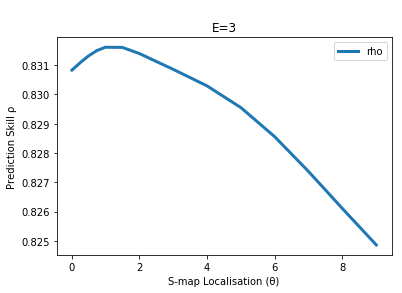

,Theta,rho
0,0.01,0.830834
1,0.10,0.830926
2,0.30,0.831130
3,0.50,0.831316
4,0.75,0.831502
5,1.00,0.831614
6,1.50,0.831608
7,2.00,0.831399
8,3.00,0.830859
9,4.00,0.830294


In [15]:
pyEDM.PredictNonlinear( dataFrame = btc_nvda_df, Tp = 10,
                        lib = "1 1300", pred = "1301 1547", 
                        E = 3, columns = "NVDA_open_scaled", 
                        target = "NVDA_open_scaled")

## Data Prediction

### Nearest Neighbor Forecasting using Simplex Projection

In [16]:
nvda_df_simplex = nvda_df[['Time', 'NVDA_open']].copy()
nvda_df_simplex.shape

(1553, 2)

In [17]:
nvda_df_simplex.head()

,Time,NVDA_open
0,2013-10-01,15.58
1,2013-10-02,15.39
2,2013-10-03,15.55
3,2013-10-04,15.36
4,2013-10-07,15.53


A Simplex Projection forecasting model using time delay embedding of NVDA at forecast interval of Tp = 1 day and the optimal embedding dimension of E = 3 is created in the below cell. The default knn = 0 sets the number of nearest neighbors to E + 1. The model is purely out of sample data. The figure below indicates that the model has 1 day forecast predictability. 

The __Simplex()__ first creates the the manifold/attractor as a matrix by taking all NVDA price points and creating a new 3d vector for each NVDA price point by applying time lags to the original data point. The library matrix/manifold is scanned for k = E + 1 nearest neighbors at each prediction point. Once 4 neighbors are found in the library matrix, a prediction is generated from the centroid of the simplex created by the 4 neighbors.

Note, since Tp = 1 the first data row will have a NaN for it's Prediction and the last Observations row will also be NaN with the time vector adjusted to accommodate Tp rows beyond the data as needed.


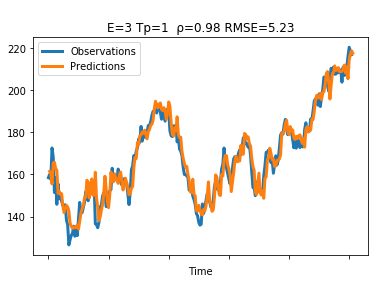

,Time,Observations,Predictions
0,2018-11-28,158.480,NaN
1,2018-11-29,160.000,161.445778
2,2018-11-30,157.750,160.396505
3,2018-12-03,172.600,155.510166
4,2018-12-04,168.240,165.434080
5,2018-12-06,151.440,165.798125
6,2018-12-07,158.460,162.719690
7,2018-12-10,145.800,162.020855
8,2018-12-11,155.560,151.003365
9,2018-12-12,148.420,151.930425


In [18]:
pyEDM.Simplex(dataFrame = nvda_df_simplex, 
              lib = "1 1300", pred = "1301 1553", E = 3, Tp = 1, knn = 0,
              embedded = False, showPlot = True, const_pred = False, 
              columns="NVDA_open", target="NVDA_open") 

Perhaps a multivariate model will perform better? Next I check to see if exogenous variables can be found to increase the predictability of the model. First the price of BTC is examined. 

### BTC and NVDA cross correlation

It was hypothesized in the CNN article that the _crypto hangover_ resulted in an NVIDIA share price drop.  Here we compute the cross correlation between the BTC and NVDA price to see if a lag exists between the two prices. 

In [19]:
btc_nvda_cc = np.correlate(btc_nvda_df['NVDA_open_scaled'].values,
                           btc_nvda_df['BTC_open_scaled'].values,
                           mode='full')

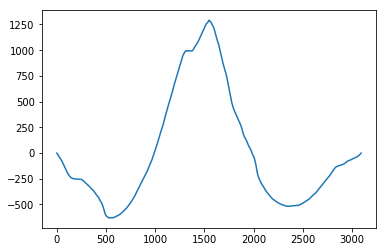

In [20]:
plt.plot(btc_nvda_cc)
plt.show()

The maximum correlation between the NVDA and BTC price is at the midpoint, indicating no lag discernable by cross correlation.  No data lag will be applied before performing the Simplex Projection using NVDA and BTC as features.

In [21]:
max_pos_btc_nvda_cc = np.where(btc_nvda_cc == np.amax(btc_nvda_cc))
percent_position_max_cc = (max_pos_btc_nvda_cc[0][0]) / (len(btc_nvda_cc)-1)
print('Percent indices position of max cross correlation = ' + str(100 * percent_position_max_cc)[:5] + '%')

Percent indices position of max cross correlation = 50.0%


### Convergent Cross Mapping 

To quantify convergence, __CCM()__ computes the cross map skill over many random subsamples of the time series.

Increasing cross map predictability as the library size increases indicates that one variable is producing a causal affect on the other.

The figure below indicates that predictability does not increase as library size increases for the NVDA_open_scaled:BTC_open_scaled cross mapping. It can be inferred that the price of BTC does not affect NVDA.

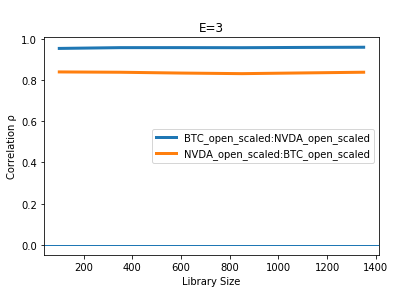

,LibSize,BTC_open_scaled:NVDA_open_scaled,NVDA_open_scaled:BTC_open_scaled
0,100.0,0.952898,0.838889
1,350.0,0.956698,0.837342
2,600.0,0.956799,0.833430
3,850.0,0.956430,0.830582
4,1100.0,0.957715,0.834052
5,1350.0,0.958612,0.837441


In [22]:
pyEDM.CCM(dataFrame = btc_nvda_df, libSizes = '100 1500 250',
          E = 3, Tp = 0, showPlot = True, 
          columns="BTC_open_scaled", sample = 100, 
          target="NVDA_open_scaled", verbose = True) 

The Convergent Cross Mapping above indicated that adding BTC as a variable will not add meaningful information to the model, however for educational purposes I will proceed and add BTC as a feature to the Simplex Projection model.

NVDA_open and BTC_open are used as the system variables and no time delay embedding is performed. The figure below indicates that adding BTC as a system variable does not increase the model predictability. 

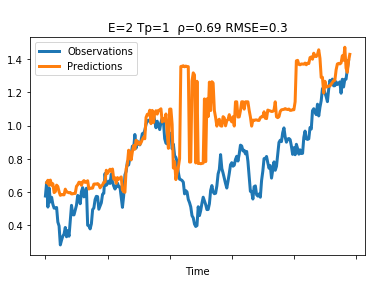

,Time,Observations,Predictions
0,2018-12-06,0.575179,NaN
1,2018-12-07,0.658112,0.655985
2,2018-12-10,0.508550,0.670232
3,2018-12-11,0.623852,0.639740
4,2018-12-12,0.539502,0.671300
5,2018-12-13,0.567500,0.640337
6,2018-12-14,0.525207,0.649333
7,2018-12-17,0.501934,0.595855
8,2018-12-18,0.503234,0.601527
9,2018-12-19,0.505951,0.640842


In [23]:
pyEDM.Simplex(dataFrame = btc_nvda_df, 
              lib = "1 1300", pred = "1301 1545", E = 2, Tp = 1,
              embedded = True, showPlot = True, const_pred = False, 
              columns="NVDA_open_scaled BTC_open_scaled", 
              target="NVDA_open_scaled") 

The process outlined above of testing if a feature increases model predictability was also implemented on stock prices of companies that supply NVDA (Taiwan Semiconductor Manufacturing (TSM), Newmont Goldcorp (NEM), and Applied Materials (AMAT)), and Federal Reserve interest rates. No external feature was discovered that added predictability to the model. 

For brevity's sake I did not include all this analysis in the published notebook, as none of these features added information to the model. I also tested using different combinations of features and embedding dimensions, but found the model that performed the best was 3D Simplex Projection of time-delay embedded NVDA for next day forecasting. If anyone is interested feel free to message me and I can send you the full notebook.

# Results

In this section I will provide sample output/predictions from the Simplex Projection model for next day price forecasting.

## Example #1

The code below trains the Simplex Projection model on the first 1000 indices of the NVDA price dataframe. The model uses an embedding of 3 and will forecast 1 day ahead.  Note that the prediction indices are not in the library (are out-of-sample). The model predicts that on 2017-09-22 NVDA price will be 174.97. 

In [24]:
pyEDM.Simplex( dataFrame = nvda_df_simplex, 
               lib = "1 1000", pred = "1001 1002", E = 3, Tp = 1, knn = 0,
               embedded = False, showPlot = False, const_pred = False, 
               columns="NVDA_open", target="NVDA_open") 

,Time,Observations,Predictions
0,2017-09-20,187.50,NaN
1,2017-09-21,181.64,175.484111
2,2017-09-22,NaN,174.979259


The actual observation on 2017-09-22 was that NVDA was 180.30. Despite being slightly off in it's prediction the model was able to correctly predict the correct price movement of NVDA decreasing from 2017-09-21 to 2017-09-22.

In [25]:
nvda_df_simplex[(nvda_df_simplex['Time']>= datetime.date(2017,9,20)) &
                (nvda_df_simplex['Time']<= datetime.date(2017,9,22))]  

,Time,NVDA_open
1000,2017-09-20,187.50
1001,2017-09-21,181.64
1002,2017-09-22,180.30


## Example #2

Again, the code below trains the  Simplex Projection model on the first 1300 indices of the NVDA price dataframe. The model uses an embedding of 3 and will forecast 1 day ahead. The model predicts that on 2018-11-30 NVDA price will be 160.39.

In [26]:
pyEDM.Simplex( dataFrame = nvda_df_simplex, 
               lib = "1 1300", pred = "1301 1302", E = 3, Tp = 1, knn = 0,
               embedded = False, showPlot = False, const_pred = False, 
               columns="NVDA_open", target="NVDA_open") 

,Time,Observations,Predictions
0,2018-11-28,158.48,NaN
1,2018-11-29,160.00,161.445778
2,2018-11-30,NaN,160.396505


The actual observation on 2018-11-30 was that NVDA was 157.75. Despite being slightly off in it's prediction the model was able to correctly predict the correct price movement of NVDA decreasing from 2018-11-29 to 2018-11-30.

In [27]:
nvda_df_simplex[(nvda_df_simplex['Time']>= datetime.date(2018,11,28)) &
                (nvda_df_simplex['Time']<= datetime.date(2018,11,30))] 

,Time,NVDA_open
1300,2018-11-28,158.48
1301,2018-11-29,160.00
1302,2018-11-30,157.75


## Example #3

Example 1 and 2 were performed on data that is included in the original data set so that the output can be validated. If this model was productionalized the full library of data would be used to predict for points that are not yet available. 

The original NVDA price data set includes all data from 10-31-2013 to 11-29-2019. In the below code the model is trained on all data points that are available from 10-31-2013 to 11-29-2019 and the prediction is made for the NVDA price on 2019-12-01. 

The model predicts that the price will be 217.66 on 2019-12-01. Although it is not available in the data set, I am writing up this project after 2019-12-01, so a simple Google search tells me that NVDA was 216.46 on 2019-12-01. As previously observed in example 1 and 2, the prediction is slightly off from the observation, but the direction of predicting that NVDA will decrease from 11-29-2019 to 2019-12-01 is correct. 

In [28]:
pyEDM.Simplex( dataFrame = nvda_df_simplex, 
               lib = "1 1551", pred = "1552 1553", E = 3, Tp = 1, knn = 0,
               embedded = False, showPlot = False, const_pred = False, 
               columns="NVDA_open", target="NVDA_open") 

,Time,Observations,Predictions
0,2019-11-27,218.67,NaN
1,2019-11-29,217.00,218.806830
2,2019-12-01,NaN,217.668772


In [29]:
print('Observation from Google search: 2019-12-01 NVDA price = 216.46')

Observation from Google search: 2019-12-01 NVDA price = 216.46


# Discussion

In this notebook the pyEDM library was used to create a Simplex Projection model using Nearest Neighbor Forecasting at an embedding dimension of 3 to predict the next day directional  movement of NVDA. The model has a high level of predictability and could have useful applications in financial trading. 

The price of BTC, supplier company stock price, and fed interest rates were examined to see if they could be used as features to increase the predictability of the model. While no external features were found that increased the predictability of the model, there are certainly dynamics of the system that are not being captured, and could be added to increase predictability.  

Since the stock market is largely affected by consumer perception/psychology, a useful feature to add to the model could be an aggregated metric of public perception of a stock based on social media feedback and news outlet articles. This would be a large endeavor in feature engineering and web scrapping, but is a potential direction for fruitful work.

For any questions/comments feel free to email me at parkcoreya@gmail.com